In [ ]:
import os
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
!pip install tensorflow-addons
import tensorflow_addons as tfa
from sklearn.model_selection import KFold, train_test_split
%load_ext tensorboard

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 3.4 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

0deg

In [ ]:
from pathlib import Path
import os.path
#image_dir = Path('/content/gdrive/MyDrive/DATA/SIAP_TRAIN/0deg_LED_resized')
image_dir = Path('/content/gdrive/MyDrive/Hasil_Train/Dataset_128/0deg_LED_resized')
#image_dir = Path('/content/gdrive/MyDrive/Test1/DATA/SIAP_TRAIN/0deg_val_resized')

90deg

In [ ]:
from pathlib import Path
import os.path
#image_dir = Path('/content/gdrive/MyDrive/Hasil_Train/open_noLED_png_resized')
image_dir = Path('/content/gdrive/MyDrive/Hasil_Train/Dataset_128/open_noLED_png_resized')

In [ ]:
filepath = pd.Series(list(image_dir.glob(r'**/*.png')), name='Filepath').astype(str)
turbidity = pd.Series(filepath.apply(lambda x: os.path.split(os.path.split(x)[0])[1]), name='Turbidity').astype(np.float)

images = pd.concat([filepath, turbidity], axis=1).sample(frac=1.0, random_state=1).reset_index(drop=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [ ]:
images

,Filepath,Turbidity
0,/content/gdrive/MyDrive/Test1/DATA/SIAP_TRAIN/...,46.4
1,/content/gdrive/MyDrive/Test1/DATA/SIAP_TRAIN/...,46.4
2,/content/gdrive/MyDrive/Test1/DATA/SIAP_TRAIN/...,9.7
3,/content/gdrive/MyDrive/Test1/DATA/SIAP_TRAIN/...,41.6
4,/content/gdrive/MyDrive/Test1/DATA/SIAP_TRAIN/...,0.8
5,/content/gdrive/MyDrive/Test1/DATA/SIAP_TRAIN/...,46.4
6,/content/gdrive/MyDrive/Test1/DATA/SIAP_TRAIN/...,9.7
7,/content/gdrive/MyDrive/Test1/DATA/SIAP_TRAIN/...,9.7
8,/content/gdrive/MyDrive/Test1/DATA/SIAP_TRAIN/...,41.6
9,/content/gdrive/MyDrive/Test1/DATA/SIAP_TRAIN/...,41.6


KFOLD VAL RESNET

In [ ]:
train_df, test_df = train_test_split(images, train_size=0.9, shuffle=True, random_state=1)
Y = train_df[['Turbidity']]

In [ ]:
def get_model():
    #Create model
    base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False, weights="imagenet", 
                                                  input_shape=(224, 224, 3), pooling='avg')
    out = base_model.output
    prediction = tf.keras.layers.Dense(1, activation="linear")(out)
    model = tf.keras.Model(inputs = base_model.input, outputs = prediction)
      
    return model

def get_model_name(k):
    return 'EfficientNet_'+str(k)+'.h5'

tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    horizontal_flip=True,
    #vertical_flip=True
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    horizontal_flip=True,
    #vertical_flip=True
)

kf = KFold(n_splits = 8)
fold_var = 1

In [ ]:
VALIDATION_R2 = []
VALIDATION_LOSS = []
VALIDATION_MSE = []
VALIDATION_MAE = []

save_dir = 'saved_models/'

In [ ]:
for train_index, val_index in kf.split(np.zeros(Y.shape[0]),Y):
  training_data = train_df.iloc[train_index]
  validation_data = train_df.iloc[val_index]
	
  train_images = train_generator.flow_from_dataframe(training_data,
                                                 x_col = "Filepath", y_col = "Turbidity",
                                                 target_size=(224, 224), color_mode='rgb',
                                                 class_mode = "raw", shuffle = True)
  val_images  = train_generator.flow_from_dataframe(validation_data,
                                                  x_col = "Filepath", y_col = "Turbidity",
                                                  target_size=(224, 224), color_mode='rgb',
                                                  class_mode = "raw", shuffle = True)
	
	# CREATE NEW MODEL
  model = get_model()
	# COMPILE NEW MODEL
  opt = tf.keras.optimizers.Adam(learning_rate=1e-4, decay=1e-6)
  model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=['mae','mse', tfa.metrics.RSquare(name="R2")])
	
	# CREATE CALLBACKS
  checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir+get_model_name(fold_var), monitor='val_loss', verbose=1, save_best_only=True, mode='min')
  callbacks_list = [checkpoint]
	# There can be other callbacks, but just showing one because it involves the model name
	# This saves the best model
	# FIT THE MODEL
  history = model.fit(train_images, epochs=100,
                      callbacks=callbacks_list,
                      validation_data=val_images)
	
	# LOAD BEST MODEL to evaluate the performance of the model
  model.load_weights("saved_models/EfficientNet_"+str(fold_var)+".h5")

  results = model.evaluate(val_images)
  results = dict(zip(model.metrics_names,results))
	
  VALIDATION_R2.append(results['R2'])
  VALIDATION_MAE.append(results['mae'])
  VALIDATION_MSE.append(results['mse'])
  VALIDATION_LOSS.append(results['loss'])
	
  tf.keras.backend.clear_session()
	
  fold_var += 1

Found 424 validated image filenames.
Found 61 validated image filenames.
16719872/16705208 [==============================] - 0s 0us/step
Epoch 1/100
14/14 [==============================] - ETA: 0s - loss: 62.4650 - mae: 62.9613 - mse: 5351.0068 - R2: -2.8645
Epoch 1: val_loss improved from inf to 59.74284, saving model to saved_models/EfficientNet_1.h5
14/14 [==============================] - 137s 8s/step - loss: 62.4650 - mae: 62.9613 - mse: 5351.0068 - R2: -2.8645 - val_loss: 59.7428 - val_mae: 60.2376 - val_mse: 4776.7246 - val_R2: -3.1580
Epoch 2/100
14/14 [==============================] - ETA: 0s - loss: 60.5585 - mae: 61.0551 - mse: 5099.5537 - R2: -2.6829
Epoch 2: val_loss did not improve from 59.74284
14/14 [==============================] - 5s 321ms/step - loss: 60.5585 - mae: 61.0551 - mse: 5099.5537 - R2: -2.6829 - val_loss: 60.0273 - val_mae: 60.5203 - val_mse: 4815.6426 - val_R2: -3.1919
Epoch 3/100
14/14 [==============================] - ETA: 0s - loss: 57.0245 - mae:

In [ ]:
model = get_model()
model.load_weights("saved_models/EfficientNet_4.h5")

EVAL

In [ ]:
model = get_model()
model.load_weights("/content/gdrive/MyDrive/Hasil_Train/Training/90DEG-EfficientNetB0-8Fold-NoAugmentation/EfficientNet_6.h5")
opt = tf.keras.optimizers.Adam(learning_rate=1e-4, decay=1e-6)
model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=['mae','mse', tfa.metrics.RSquare(name="R2")])

-

In [ ]:
print(VALIDATION_LOSS)
print(VALIDATION_R2)

[]
[]


COBA-COBA

**PREPARING DATASET**

In [ ]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Turbidity',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='raw',
    shuffle=False,
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Turbidity',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='raw',
    shuffle=False
)

Found 485 validated image filenames.
Found 54 validated image filenames.


Validation

In [ ]:
val_images = test_generator.flow_from_dataframe(
    dataframe=images,
    x_col='Filepath',
    y_col='Turbidity',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='raw',
    shuffle=False
)

Found 539 validated image filenames.


In [ ]:
val_pred = np.squeeze(model.predict(val_images))
val_true = val_images.labels
val_residuals = val_true - val_pred

In [ ]:
train_pred = np.squeeze(model.predict(train_images))
train_true = train_images.labels
train_residuals = train_true - train_pred

test_pred = np.squeeze(model.predict(test_images))
test_true = test_images.labels
test_residuals = test_true - test_pred

In [ ]:
from sklearn.metrics import r2_score as r2
r2_train = r2(train_true,train_pred)
r2_test = r2(test_true,test_pred)
r2_val = r2(val_true,val_pred)
print(round(r2_train,3))
print(round(r2_test,3))
print(round(r2_val,3))

0.986
0.981
0.986


In [ ]:
from sklearn.metrics import mean_absolute_error as MAE
MAE_train = MAE(train_true,train_pred)
MAE_test = MAE(test_true,test_pred)
MAE_val = MAE(val_true,val_pred)
print(round(MAE_train,3))
print(round(MAE_test,3))
print(round(MAE_val,3))

2.644
3.386
2.409


In [ ]:
from sklearn.metrics import mean_squared_error as MSE
MSE_train = MSE(train_true,train_pred)
MSE_test = MSE(test_true,test_pred)
MSE_val = MSE(val_true,val_pred)
print(round(MSE_train,3))
print(round(MSE_test,3))
print(round(MSE_val,3))

19.554
18.87
18.608


In [ ]:
print(test_true)

[110.5   67.75  83.25  74.45  33.4   10.25 122.3   84.7   16.2   57.3
  24.85   9.45  57.3   74.45  56.4   43.    55.7   47.5   51.15  67.
  32.1   71.    85.1   41.6   71.    58.8   68.3   29.6   40.5    2.6
  75.45  12.95 112.5  122.3   58.8   53.05  80.7   91.3   85.1   75.45
  23.5   95.9  118.     7.2   38.5   71.55 123.9   46.6   53.05  78.6
  20.3   61.3   78.6   32.1 ]


In [ ]:
print(test_pred)

[113.3677    73.19059   79.057175  76.44301   28.976994  11.344569
 123.25112   88.180984  11.927966  62.93232   19.803148   9.56907
  60.954227  73.45484   59.30517   45.695362  60.57547   45.096806
  50.416832  64.334656  29.65243   64.74644   90.6881    46.70764
  72.88776   59.025745  67.07319   34.24073   45.16554    4.81274
  74.38591   14.678242 118.26081   93.521416  57.253723  54.085342
  77.47403   91.88859   88.54832   72.09013   26.620028  94.900276
 117.351456   5.669463  37.366745  72.1853   121.45534   48.664215
  56.24238   71.38719   15.63998   57.201237  81.12064   33.672733]


In [ ]:
table = pd.DataFrame()
table['True'] = test_true.tolist()
table['Prediksi'] = test_pred.tolist()
print(table)

      True    Prediksi
0   110.50  113.367699
1    67.75   73.190590
2    83.25   79.057175
3    74.45   76.443008
4    33.40   28.976994
5    10.25   11.344569
6   122.30  123.251122
7    84.70   88.180984
8    16.20   11.927966
9    57.30   62.932320
10   24.85   19.803148
11    9.45    9.569070
12   57.30   60.954227
13   74.45   73.454842
14   56.40   59.305168
15   43.00   45.695362
16   55.70   60.575470
17   47.50   45.096806
18   51.15   50.416832
19   67.00   64.334656
20   32.10   29.652430
21   71.00   64.746437
22   85.10   90.688103
23   41.60   46.707642
24   71.00   72.887756
25   58.80   59.025745
26   68.30   67.073189
27   29.60   34.240730
28   40.50   45.165539
29    2.60    4.812740
30   75.45   74.385910
31   12.95   14.678242
32  112.50  118.260811
33  122.30   93.521416
34   58.80   57.253723
35   53.05   54.085342
36   80.70   77.474030
37   91.30   91.888588
38   85.10   88.548317
39   75.45   72.090134
40   23.50   26.620028
41   95.90   94.900276
42  118.00 

In [ ]:
table.sort_values(['True', 'Prediksi'], ascending=[True, False], inplace=True)
print(table)

      True    Prediksi
29    2.60    4.812740
43    7.20    5.669463
11    9.45    9.569070
5    10.25   11.344569
31   12.95   14.678242
8    16.20   11.927966
50   20.30   15.639980
40   23.50   26.620028
10   24.85   19.803148
27   29.60   34.240730
53   32.10   33.672733
20   32.10   29.652430
4    33.40   28.976994
44   38.50   37.366745
28   40.50   45.165539
23   41.60   46.707642
15   43.00   45.695362
47   46.60   48.664215
17   47.50   45.096806
18   51.15   50.416832
48   53.05   56.242378
35   53.05   54.085342
16   55.70   60.575470
14   56.40   59.305168
9    57.30   62.932320
12   57.30   60.954227
25   58.80   59.025745
34   58.80   57.253723
51   61.30   57.201237
19   67.00   64.334656
1    67.75   73.190590
26   68.30   67.073189
24   71.00   72.887756
21   71.00   64.746437
45   71.55   72.185303
3    74.45   76.443008
13   74.45   73.454842
30   75.45   74.385910
39   75.45   72.090134
52   78.60   81.120644
49   78.60   71.387192
36   80.70   77.474030
2    83.25 

In [ ]:
table.to_excel('output1.xlsx') 

In [ ]:
Ffold = '8-90'

if not os.path.exists(f'saved_model/{fold}'):
  os.makedirs(f'saved_model/{fold}')

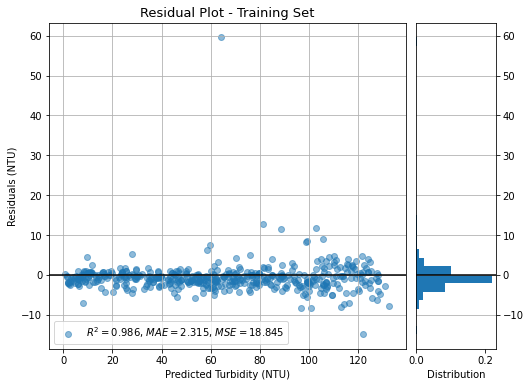

In [ ]:
f, axs = plt.subplots(1, 2, figsize=(8,6), gridspec_kw={'width_ratios': [9, 2]})

axs[0].scatter(train_pred,train_residuals, label=f'$R^2=${0.986}, $MAE=${2.315}, $MSE=${18.845}', alpha=0.5, color='tab:blue')
axs[0].set_title('Residual Plot - Training Set', fontsize=13)           
axs[0].set_ylabel('Residuals (NTU)', fontsize=10)
axs[0].set_xlabel('Predicted Turbidity (NTU)', fontsize=10)      
axs[0].axhline(0, color='black')
axs[0].legend()
axs[0].grid()

axs[1].hist(train_residuals, bins=35, orientation="horizontal", density=True)
axs[1].axhline(0, color='black')
axs[1].set_xlabel('Distribution', fontsize=10)  
axs[1].yaxis.tick_right()
axs[1].grid(axis='y')

plt.subplots_adjust(wspace=0.05)
plt.savefig(f'saved_model/{fold}/ResidualPlotTrain_Fold{fold}.png', dpi=300)
plt.show()

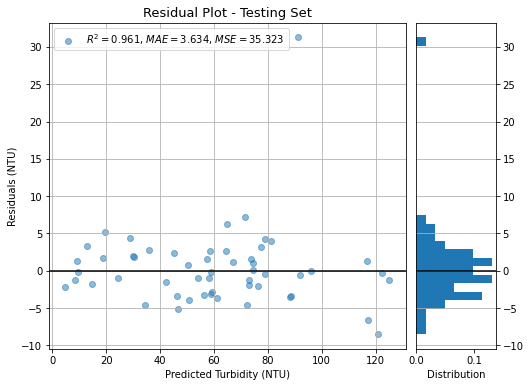

In [ ]:
f, axs = plt.subplots(1, 2, figsize=(8,6), gridspec_kw={'width_ratios': [9, 2]})

axs[0].scatter(test_pred,test_residuals, label=f'$R^2=${0.961}, $MAE=${3.634}, $MSE=${35.323}', alpha=0.5, color='tab:blue')
axs[0].set_title('Residual Plot - Testing Set', fontsize=13)           
axs[0].set_ylabel('Residuals (NTU)', fontsize=10)
axs[0].set_xlabel('Predicted Turbidity (NTU)', fontsize=10)      
axs[0].axhline(0, color='black')
axs[0].legend()
axs[0].grid()

axs[1].hist(test_residuals, bins=35, orientation="horizontal", density=True)
axs[1].axhline(0, color='black')
axs[1].set_xlabel('Distribution', fontsize=10)  
axs[1].yaxis.tick_right()
axs[1].grid(axis='y')

plt.subplots_adjust(wspace=0.05)
plt.savefig(f'saved_model/{fold}/ResidualPlotTest_Fold{fold}.png', dpi=300)
plt.show()

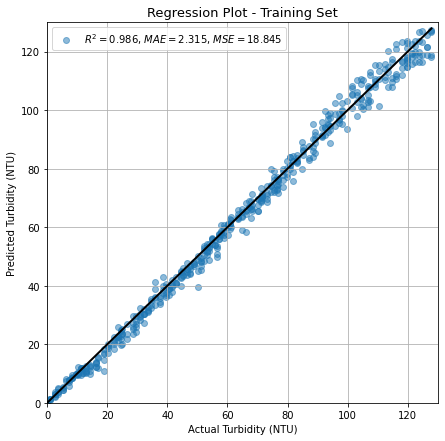

In [ ]:
fig, ax = plt.subplots(1,figsize=(7,7))

ax.scatter(train_true,train_pred, label=f'$R^2=${0.986}, $MAE=${2.315}, $MSE=${18.845}', color='tab:blue', alpha=0.5)
theta = np.polyfit(train_true, train_pred, 1)
y_line = theta[1] + theta[0] * train_true
ax.plot([train_true.min(), train_true.max()], [train_true.min(),train_true.max()], 'k-', lw=2)
ax.set_xlabel('Actual Turbidity (NTU)', fontsize=10)
ax.set_ylabel('Predicted Turbidity (NTU)', fontsize=10)
ax.set_title(f'Regression Plot - Training Set', fontsize=13)
ax.set_xlim([0, 130])
ax.set_ylim([0, 130])
ax.grid()
ax.legend()

plt.subplots_adjust(wspace=0.3)
#plt.savefig(f'saved_model/{fold}/RegressionPlotTrain_Fold{fold}.png', dpi=300)
plt.show()

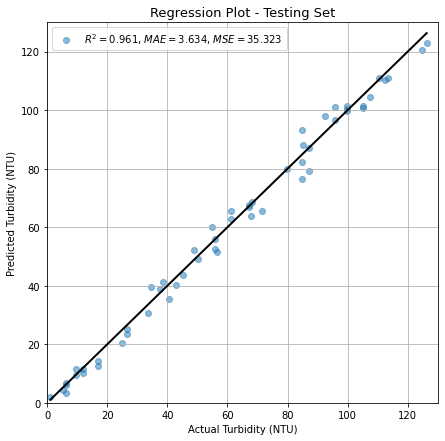

In [ ]:
fig, ax = plt.subplots(1,figsize=(7,7))

ax.scatter(test_true,test_pred, label=f'$R^2=${0.961}, $MAE=${3.634}, $MSE=${35.323}', color='tab:blue', alpha=0.5)
theta2 = np.polyfit(test_true, test_pred, 1)
y_line2 = theta2[1] + theta2[0] * test_true
ax.plot([test_true.min(), test_true.max()], [test_true.min(), test_true.max()], 'k-', lw=2)
ax.set_xlabel('Actual Turbidity (NTU)', fontsize=10)
ax.set_ylabel('Predicted Turbidity (NTU)', fontsize=10)
ax.set_title(f'Regression Plot - Testing Set', fontsize=13)
ax.set_xlim([0, 130])
ax.set_ylim([0, 130])
ax.grid()
ax.legend()

plt.subplots_adjust(wspace=0.3)
#plt.savefig(f'saved_model/{fold}/RegressionPlotTest_Fold{fold}.png', dpi=300)
plt.show()

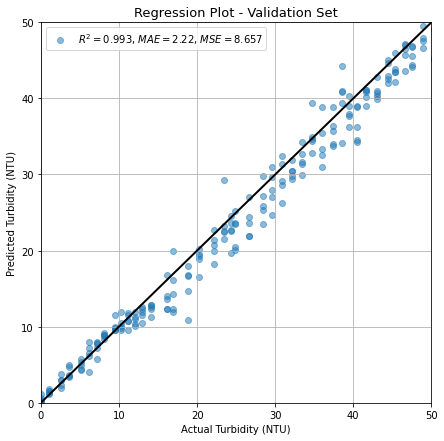

In [ ]:
fig, ax = plt.subplots(1,figsize=(7,7))

ax.scatter(val_true,val_pred, label=f'$R^2=${round(r2_val,3)}, $MAE=${round(MAE_val,3)}, $MSE=${round(MSE_val,3)}', color='tab:blue', alpha=0.5)
theta2 = np.polyfit(val_true, val_pred, 1)
y_line2 = theta2[1] + theta2[0] * val_true
ax.plot([val_true.min(), val_true.max()], [val_true.min(), val_true.max()], 'k-', lw=2)
ax.set_xlabel('Actual Turbidity (NTU)', fontsize=10)
ax.set_ylabel('Predicted Turbidity (NTU)', fontsize=10)
ax.set_title(f'Regression Plot - Validation Set', fontsize=13)
ax.set_xlim([0, 50])
ax.set_ylim([0, 50])
ax.grid()
ax.legend()

plt.subplots_adjust(wspace=0.3)
#plt.savefig(f'saved_model/{fold}/RegressionPlotTest_Fold{fold}.png', dpi=300)
plt.show()

Copy to Drive (Grafik)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

save_path = f"/content/gdrive/MyDrive/Hasil_Train/Training/90DEG-EfficientNetB0-Train0.9-CV8FoldAverage"
if not os.path.exists(save_path):
  os.makedirs(save_path)

oripath = "saved_model/."
!cp -a "{oripath}" "{save_path}" # copies files to google drive

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Copy to Drive (Model)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

save_path = f"/content/gdrive/MyDrive/Hasil_Train/Training/90DEG-EfficientNetB0-8Fold-BothAugmentation"
if not os.path.exists(save_path):
  os.makedirs(save_path)

oripath = "saved_models/."
!cp -a "{oripath}" "{save_path}" # copies files to google drive

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
